# Capstone Project - The Battle of the Neighborhoods (Week 2)

***

# Table of contents
* [Introduction: Business Problem](#intro)
* [Data](#data)
* [Methodology](#method)
* [Results](#result)
* [Discussion](#discuss)
* [Conclusion](#conclude)

---

# Introduction: Business Problem <a name="intro"></a>
Toronto downtown core has a ton of restaurants of all sizes and cuisine types because of high foot traffic and these locations also has a relatively high cost of operation which comes as no surprise. So if someone would like to start a cost-efficient restaurant business with potentially low cost of operation, they should ideally take all Toronto neighborhoods into consideration in order to pick the best location. Therefore, for this project, the stakeholder/audience is anyone who is looking to find the best location to start a restaurant business. This study will explore various factors such as neighborhood population, crime rate, existing businesses in the area, etc. 

In order to have a successful restaurant business in a given area, there are number of extrinsic factors that we need to take into consideration. For purpose of this project, we will assume that below is the top 3 requirement in order of priority:
1. Less number of existing restaurant businesses
2. Neighborhood population
3. Low crime rate.

For criteria #1, we will use the Foursquare API to find the top 10 most common nearby venues. We will then look at the Toronto crime data to further narrow down our search for the neighborhood which fits criteria #2 and #3 best.

The target audience of this study is anyone who is looking to start a restaurant business in Toronto area and would like to pick a locatation in relatively low crime rate so that their business have better chance of thriving. 

# Data <a name="data"></a>
We will be using the [Toronto Neighbourhoods Boundary File][crime] from [Kaggle][kaggle] which includes 2014-2019 Crime Data by Neighbourhood. Yearly counts are available for Assault, Auto Theft, Break and Enter, Robbery, Theft Over and Homicide. This data also includes the neighbourhood population based on 2016 Census. The population data can be useful for two things; 1) To normalize the data from yearly crime count to crime per 1000 people and 2) To use it as an indicator for restaurant business demand. 

From this crime data, we can extract features related to different types of crime such as Assault, Auto Theft, Break and Enter, Robbery, Theft Over and Homicide committed in Toronto area ranging from 2014-2019.

In addition to the crime data, we will also be using [geopy.geocoders][geocoder] library to get the coordinates for each of the neighbourhood in the crime data. We will then use the coordinates to explore the Foursqure API to enrinch out dataset by finding nearby venue categories for each neighbourhood. Based on Foursquare venue data, we can summarize how many existing restaurants there are in each neighbourhood.

[crime]: https://www.kaggle.com/alincijov/toronto-crime-rate-per-neighbourhood
[geocoder]: https://pypi.org/project/geocoder/
[kaggle]: https://www.kaggle.com/

In [1]:
import pandas as pd
import numpy as np

In [2]:
pd.set_option('display.max_columns', None)

We will start by reading the crime data so that we have the list of potential neighbourhoods to start the restaurant business.

In [3]:
crime_rate = 'data/Neighbourhood_Crime_Rates_(Boundary_File)_.csv'

In [4]:
df = pd.read_csv(crime_rate)

In [5]:
df.head()

,OBJECTID,Neighbourhood,Hood_ID,Population,Assault_2014,Assault_2015,Assault_2016,Assault_2017,Assault_2018,Assault_2019,Assault_AVG,Assault_CHG,Assault_Rate_2019,AutoTheft_2014,AutoTheft_2015,AutoTheft_2016,AutoTheft_2017,AutoTheft_2018,AutoTheft_2019,AutoTheft_AVG,AutoTheft_CHG,AutoTheft_Rate_2019,BreakandEnter_2014,BreakandEnter_2015,BreakandEnter_2016,BreakandEnter_2017,BreakandEnter_2018,BreakandEnter_2019,BreakandEnter_AVG,BreakandEnter_CHG,BreakandEnter_Rate_2019,Homicide_2014,Homicide_2015,Homicide_2016,Homicide_2017,Homicide_2018,Homicide_2019,Homicide_AVG,Homicide_CHG,Homicide_Rate_2019,Robbery_2014,Robbery_2015,Robbery_2016,Robbery_2017,Robbery_2018,Robbery_2019,Robbery_AVG,Robbery_CHG,Robbery_Rate_2019,TheftOver_2014,TheftOver_2015,TheftOver_2016,TheftOver_2017,TheftOver_2018,TheftOver_2019,TheftOver_AVG,TheftOver_CHG,TheftOver_Rate_2019,Shape__Area,Shape__Length
0,1,Yonge-St.Clair,97,12528,20,29,39,27,34,37,31.0,0.09,295.3,2,3,7,2,6,6,4.3,0.00,47.9,37,20,12,19,24,28,23.3,0.17,223.5,0,0,0,0,0,0,0.0,0.0,0.0,6,5,6,8,5,4,5.7,-0.20,31.9,4,5,8,0,3,6,4.3,1.00,47.9,1.161315e+06,5873.270582
1,2,York University Heights,27,27593,271,296,361,344,357,370,333.2,0.04,1340.9,105,100,105,92,92,144,106.3,0.57,521.9,107,139,98,105,122,108,113.2,-0.11,391.4,1,0,2,1,1,0,0.8,-1.0,0.0,59,84,70,75,88,79,75.8,-0.10,286.3,30,46,37,39,38,28,36.3,-0.26,101.5,1.324666e+07,18504.777326
2,3,Lansing-Westgate,38,16164,44,80,68,85,75,72,70.7,-0.04,445.4,19,22,27,26,16,32,23.7,1.00,198.0,34,27,41,42,50,39,38.8,-0.22,241.3,0,0,0,0,10,0,1.7,-1.0,0.0,11,5,9,17,35,11,14.7,-0.69,68.1,4,5,5,11,6,11,7.0,0.83,68.1,5.346186e+06,11112.109625
3,4,Yorkdale-Glen Park,31,14804,106,136,174,161,175,209,160.2,0.19,1411.8,63,53,41,52,63,61,55.5,-0.03,412.1,51,57,66,58,64,84,63.3,0.31,567.4,1,1,1,1,2,1,1.2,-0.5,6.8,23,21,24,35,44,42,31.5,-0.05,283.7,23,14,26,23,20,29,22.5,0.45,195.9,6.038326e+06,10079.426920
4,5,Stonegate-Queensway,16,25051,88,71,76,95,87,82,83.2,-0.06,327.3,34,29,12,32,31,34,28.7,0.10,135.7,71,45,49,49,39,64,52.8,0.64,255.5,0,0,0,0,0,0,0.0,0.0,0.0,21,14,16,26,25,22,20.7,-0.12,87.8,7,8,4,6,7,4,6.0,-0.43,16.0,7.946202e+06,11853.189878


In [6]:
df.shape

(140, 60)

Lets check if we have any NULL value.

In [7]:
null_counts = df.isna().sum()
null_counts [null_counts > 0]

Series([], dtype: int64)

## Getting Latitude, Longitude Coordinates

Now that we have our list of neighbourhoods, we can go ahead and get the coordinates for each neighborhood. These coordinates will then be joined back to the dataframe.

**Selected feature(s):** *Neighbourhood*<br>**Data Source:** *Toronto Crime Data*

In [8]:
from geopy.geocoders import Nominatim

In [9]:
lat = []
lng = []
for i in df['Neighbourhood']:
    #address = 'Yonge-St.Clair, Toronto, ON'
    geolocator = Nominatim(user_agent="my_agent")
    location = geolocator.geocode(i + ', Toronto, ON')
    print(i, end=', ')
    try:
        lat.append(location.latitude)
        lng.append(location.longitude)
    except:
        lat.append(np.nan)
        lng.append(np.nan)
print('\n*** Done! We have the coordinates!')

Yonge-St.Clair, York University Heights, Lansing-Westgate, Yorkdale-Glen Park, Stonegate-Queensway, Tam O'Shanter-Sullivan, The Beaches, Thistletown-Beaumond Heights, Thorncliffe Park, Danforth East York, Humewood-Cedarvale, Islington-City Centre West, Danforth, Rustic, Scarborough Village, South Parkdale, South Riverdale, St.Andrew-Windfields, Taylor-Massey, Humber Summit, Humbermede, Centennial Scarborough, Church-Yonge Corridor, Clairlea-Birchmount, Cliffcrest, Flemingdon Park, Corso Italia-Davenport, Ionview, Junction Area, Broadview North, Princess-Rosethorn, North Riverdale, Etobicoke West Mall, Forest Hill North, Glenfield-Jane Heights, Greenwood-Coxwell, Guildwood, Trinity-Bellwoods, Victoria Village, Waterfront Communities-The Island, West Hill, West Humber-Clairville, Westminster-Branson, Kennedy Park, Kingsview Village-The Westway, Bayview Woods-Steeles, Clanton Park, Keelesdale-Eglinton West, O'Connor-Parkview, Old East York, Casa Loma, Kensington-Chinatown, Kingsway South,

Lets add the coordinates back to our crime dataframe.

In [10]:
df['Latitude'] = lat
df['Longitude'] = lng
df.dropna(axis=0, inplace = True)

In [11]:
df.shape

(109, 62)

In [12]:
df.head()

,OBJECTID,Neighbourhood,Hood_ID,Population,Assault_2014,Assault_2015,Assault_2016,Assault_2017,Assault_2018,Assault_2019,Assault_AVG,Assault_CHG,Assault_Rate_2019,AutoTheft_2014,AutoTheft_2015,AutoTheft_2016,AutoTheft_2017,AutoTheft_2018,AutoTheft_2019,AutoTheft_AVG,AutoTheft_CHG,AutoTheft_Rate_2019,BreakandEnter_2014,BreakandEnter_2015,BreakandEnter_2016,BreakandEnter_2017,BreakandEnter_2018,BreakandEnter_2019,BreakandEnter_AVG,BreakandEnter_CHG,BreakandEnter_Rate_2019,Homicide_2014,Homicide_2015,Homicide_2016,Homicide_2017,Homicide_2018,Homicide_2019,Homicide_AVG,Homicide_CHG,Homicide_Rate_2019,Robbery_2014,Robbery_2015,Robbery_2016,Robbery_2017,Robbery_2018,Robbery_2019,Robbery_AVG,Robbery_CHG,Robbery_Rate_2019,TheftOver_2014,TheftOver_2015,TheftOver_2016,TheftOver_2017,TheftOver_2018,TheftOver_2019,TheftOver_AVG,TheftOver_CHG,TheftOver_Rate_2019,Shape__Area,Shape__Length,Latitude,Longitude
0,1,Yonge-St.Clair,97,12528,20,29,39,27,34,37,31.0,0.09,295.3,2,3,7,2,6,6,4.3,0.00,47.9,37,20,12,19,24,28,23.3,0.17,223.5,0,0,0,0,0,0,0.0,0.0,0.0,6,5,6,8,5,4,5.7,-0.20,31.9,4,5,8,0,3,6,4.3,1.00,47.9,1.161315e+06,5873.270582,43.688078,-79.394396
1,2,York University Heights,27,27593,271,296,361,344,357,370,333.2,0.04,1340.9,105,100,105,92,92,144,106.3,0.57,521.9,107,139,98,105,122,108,113.2,-0.11,391.4,1,0,2,1,1,0,0.8,-1.0,0.0,59,84,70,75,88,79,75.8,-0.10,286.3,30,46,37,39,38,28,36.3,-0.26,101.5,1.324666e+07,18504.777326,43.758781,-79.519434
2,3,Lansing-Westgate,38,16164,44,80,68,85,75,72,70.7,-0.04,445.4,19,22,27,26,16,32,23.7,1.00,198.0,34,27,41,42,50,39,38.8,-0.22,241.3,0,0,0,0,10,0,1.7,-1.0,0.0,11,5,9,17,35,11,14.7,-0.69,68.1,4,5,5,11,6,11,7.0,0.83,68.1,5.346186e+06,11112.109625,43.758950,-79.422556
3,4,Yorkdale-Glen Park,31,14804,106,136,174,161,175,209,160.2,0.19,1411.8,63,53,41,52,63,61,55.5,-0.03,412.1,51,57,66,58,64,84,63.3,0.31,567.4,1,1,1,1,2,1,1.2,-0.5,6.8,23,21,24,35,44,42,31.5,-0.05,283.7,23,14,26,23,20,29,22.5,0.45,195.9,6.038326e+06,10079.426920,43.703434,-79.452918
4,5,Stonegate-Queensway,16,25051,88,71,76,95,87,82,83.2,-0.06,327.3,34,29,12,32,31,34,28.7,0.10,135.7,71,45,49,49,39,64,52.8,0.64,255.5,0,0,0,0,0,0,0.0,0.0,0.0,21,14,16,26,25,22,20.7,-0.12,87.8,7,8,4,6,7,4,6.0,-0.43,16.0,7.946202e+06,11853.189878,43.621950,-79.523499


## Using Foursquare API to Find Nearby Venues

In this section, we will use the Foursqure API to explore nearby venues for each neighbourhood and extract the various business categories that currently exists in the area. We can then see what sort of businesses are common in the area and find potential market gap in each neighbourhood.

We will limit the neighbourhood search radius to 500 and limit the venue limit to 100.

**Selected feature(s):** *Neighbourhood, Latitude, Longitude*<br>**Data Source:** *Toronto Crime Data*

In [13]:
import requests

In [14]:
client_id = '3XJEILA23SIXAM3JXPCJWTXX5CWYJJV03FPIEJXU5M4AT3O5'
client_secret = 'GCMG41IDIBMYTI0PR5CK2F0JDMHPJTALHPXJAJ0JAVGU0KMC'
version = '20210206'

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, limit=150):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
        print(name, end=', ')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            client_id, 
            client_secret, 
            version, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        try:
            results = requests.get(url).json()['response']['groups'][0]['items']

            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except:
            print('***\tError with {}'.format(name))
            quit()

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print('\n*** Done!')
    return(nearby_venues)

Venue categories will be assigned to the toronto_venues dataframe for further analysis in the next section.

In [16]:
toronto_venues = getNearbyVenues(names=df['Neighbourhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Yonge-St.Clair, York University Heights, Lansing-Westgate, Yorkdale-Glen Park, Stonegate-Queensway, The Beaches, Thorncliffe Park, Danforth East York, Humewood-Cedarvale, Islington-City Centre West, Danforth, Rustic, Scarborough Village, South Parkdale, South Riverdale, St.Andrew-Windfields, Taylor-Massey, Humber Summit, Centennial Scarborough, Church-Yonge Corridor, Cliffcrest, Flemingdon Park, Corso Italia-Davenport, Ionview, Junction Area, Broadview North, North Riverdale, Etobicoke West Mall, Forest Hill North, Glenfield-Jane Heights, Guildwood, Trinity-Bellwoods, Victoria Village, Waterfront Communities-The Island, West Hill, West Humber-Clairville, Kennedy Park, Bayview Woods-Steeles, Clanton Park, Keelesdale-Eglinton West, O'Connor-Parkview, Old East York, Casa Loma, Kingsway South, Runnymede-Bloor West Village, Forest Hill South, Henry Farm, Annex, Humber Heights-Westmount, Roncesvalles, University, Hillcrest Village, Mount Dennis, Dorset Park, Edenbridge-Humber Valley, Newtonb

In [17]:
toronto_venues.head()

,Neighbourhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Yonge-St.Clair,43.688078,-79.394396,The Bagel House,43.687374,-79.393696,Bagel Shop
1,Yonge-St.Clair,43.688078,-79.394396,Capocaccia Café,43.685915,-79.393305,Italian Restaurant
2,Yonge-St.Clair,43.688078,-79.394396,9bars,43.688660,-79.391940,Café
3,Yonge-St.Clair,43.688078,-79.394396,Vita Integrative Health Clinic,43.689500,-79.394744,Chiropractor
4,Yonge-St.Clair,43.688078,-79.394396,Daeco Sushi,43.687838,-79.395652,Sushi Restaurant


In [18]:
toronto_venues.shape

(2514, 7)

In [19]:
print("Total number of unique business category: {}".format(len(toronto_venues["Venue Category"].unique())))

Total number of unique business category: 272


# Methodology: Exploratory Data Analysis <a name="method"></a>

Now we have two dataframes to work with:
1. **toronto_venues**: Contains Neighbourhood list, their coordinates, and their respecitve venue categories in a 500m radius. 
2. **df**: Contains Neighbourhood list, Population, counts of crime (Assault, Auto Theft, Break and Enter, Robbery, Theft Over and Homicide) between the years 2014-2019.

So lets break down our analysis into two phases:
1. Analysis on venue category dataframe where we will convert the categories into numerical data inorder to fit the dataframe to K-means cluster.
2. Analysis on crime dataframe where we will calculate the yearly total crime count for each neighborhood.

## Analysis on Venue Category

Lets do one-hot encoding on the venues and group them by their neighborhoods so that we can convert the data to numerical value which can then be used for K-means clustering to cluster the dataset based on our feature selection.

**Selected feature(s):** *Neighbourhood, Venue Category*<br>**Data Source:** *Toronto Crime Data, Foursquare*

In [20]:
df_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
df_onehot.insert(0, 'Neighbourhood', toronto_venues['Neighbourhood'])
df_onehot.head()

,Neighbourhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach,Beach Bar,Beer Bar,Beer Store,Big Box Store,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Event Space,Factory,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hong Kong Restaurant,Hotel,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Latin American Restaurant,Laundromat,Lawyer,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Marijuana Dispensary,Market,Martial Arts School,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Moving Target,Museum,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Lab,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Rock Climbing Spot,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stationery Store,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Syrian Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Tree,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Yonge-St.Clair,0,0,0,0,0,0,0

In [21]:
df_onehot.shape

(2514, 273)

Now our dataframe **df_onehot** contains Neighbourhood name along with their various venue categories. However, we can see that our onehot encoding process has created a new record for each venue category. So inorder to represent this data more conmprehensively, lets group this dataset by Neighbourhood and use the mean value for the venue category.

In [22]:
df_group = df_onehot.groupby('Neighbourhood').mean().reset_index()
df_group.head()

,Neighbourhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach,Beach Bar,Beer Bar,Beer Store,Big Box Store,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Event Space,Factory,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hong Kong Restaurant,Hotel,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Latin American Restaurant,Laundromat,Lawyer,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Marijuana Dispensary,Market,Martial Arts School,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Moving Target,Museum,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Lab,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Rock Climbing Spot,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stationery Store,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Syrian Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Tree,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt North,0.0,0.0,0.0,

Here, we create a function that returns the top N most common venue for a given Neighbourhood. Since we will be doining calculation for each neighborhood, creating a function for this task makes it much more efficient.

In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now lets see what are the top 10 most common venue category for each neighborhood and assign it to our new dataframe **neighborhoods_venues_sorted**.

In [24]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = df_group['Neighbourhood']

for ind in np.arange(df_group.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_group.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt North,Bakery,Bank,Chinese Restaurant,Beer Store,Discount Store,Juice Bar,Frozen Yogurt Shop,Fried Chicken Joint,Sporting Goods Shop,Clothing Store
1,Alderwood,Pizza Place,Pharmacy,Sandwich Place,Gym,Coffee Shop,Skating Rink,Pub,Eastern European Restaurant,Dog Run,Donut Shop
2,Annex,Pizza Place,Gym,Grocery Store,Sushi Restaurant,Thai Restaurant,Park,Bistro,Creperie,Burrito Place,Sandwich Place
3,Banbury-Don Mills,Japanese Restaurant,Sushi Restaurant,Coffee Shop,Park,Gas Station,Yoga Studio,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant
4,Bathurst Manor,Korean Restaurant,Grocery Store,Coffee Shop,Bakery,Ice Cream Shop,Café,Mexican Restaurant,Eastern European Restaurant,Bar,Chinese Restaurant


### K-Means Clustering

In this section, we will use K-means clustering to segregate each row based on their data points. This will allow us to visualize the market gap in terms of what businesses are currently available in the neighbourhood.

**Selected feature(s):** *Venue Category*<br>**Data Source:** *Foursquare*

In [25]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Since we have to select a K value for clustering, we can use the elbow method to find our best K value. 

Using a K range from 1 to 10, we will compare the inertia value on each K so that we can pick the best K value.
Inertia is the sum of distances of samples to their closest cluster center.

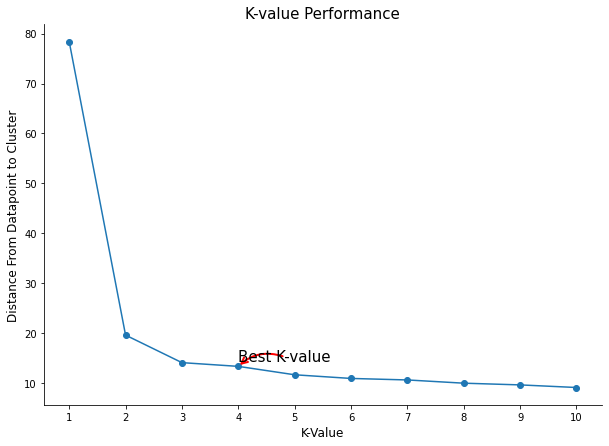

In [48]:
Ks = range(1, 11)
km = [KMeans(n_clusters=i) for i in Ks]
#df_cluster = df_group.drop('Neighbourhood', axis = 1).drop('Cluster Labels', axis = 1)
df_cluster = df_group.drop('Neighbourhood', axis = 1)
distance = [km[i].fit(df_cluster).inertia_ for i in range(len(km))]

f, ax = plt.subplots(figsize=(10, 7))
plt.plot(Ks, distance, marker='o')
plt.xlabel("K-Value")
plt.ylabel("Distance From Datapoint to Cluster")
plt.title("K-value Performance")
plt.xticks(np.linspace(1,len(Ks),len(Ks)))
#plt.xlim(0,max(Ks))
#plt.ylim(10,max(distance) + 1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.annotate("Best K-value"
            ,xy=(4,distance[3])
            ,xytext=(4,distance[3]+1)
            ,arrowprops=dict(arrowstyle='->', connectionstyle='arc3, rad=0.3', color='red', lw=2)
            ,fontsize=15
           )
plt.show()

As we can see by the elbow graph, K value of 3 is where the change in distance score diminishes. So by the elbow graph method, K value of 3 is the ideal choice. However, this method is only a good starting point to find our best K. So we will experiment with K value of 3 and 4 to see which one presents use with a more distinct dataset.

In [27]:
kclusters = 4
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_cluster)

In [28]:
df_cluster.shape

(109, 272)

In [29]:
kmeans.labels_

array([2, 0, 2, 2, 2, 2, 0, 3, 0, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 0,
       2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2,
       2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2],
      dtype=int32)

Lets add the cluster labels back to our dataframe

In [30]:
df_group['Cluster Labels'] = kmeans.labels_
df_group.head()

,Neighbourhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach,Beach Bar,Beer Bar,Beer Store,Big Box Store,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Event Space,Factory,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hong Kong Restaurant,Hotel,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Latin American Restaurant,Laundromat,Lawyer,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Marijuana Dispensary,Market,Martial Arts School,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Moving Target,Museum,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Lab,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Rock Climbing Spot,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stationery Store,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Syrian Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Tree,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Cluster Labels
0,Agincourt Nor

Since we have 268 features, it is not possible to visualize each feature on the cluster. So we will use PCA module to estimate the principal component from our features and reduce our feature down to 2 and visualize how the clusters are distributed.

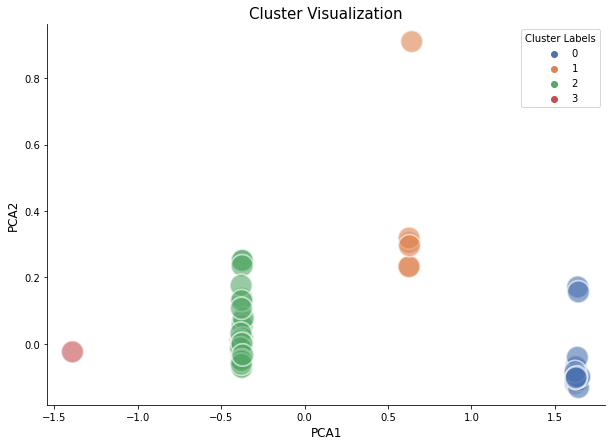

In [31]:
df_temp = df_group.drop('Neighbourhood', axis=1)
reduced_data = PCA(n_components=2).fit_transform(df_temp)
result = pd.DataFrame(reduced_data, columns=['pca1','pca2'])

f, ax1 = plt.subplots(figsize=(10, 7))
sns.scatterplot(x="pca1", y="pca2", hue=df_temp['Cluster Labels'], s=500, alpha=0.6, data=result, palette="deep")
ax1.set_title("Cluster Visualization")
ax1.set_xlabel("PCA1")
ax1.set_ylabel("PCA2")
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
plt.show()

### Mapping the Cluster

Now lets combine our 3 dataframes created above and also select the features that will be helpful to visualize our data as following. These 3 dataframes can be joined by using Neighborhood as index.
* df (Selected features: Neighbourhood, Population, Latitude, Longitude)
* neighborhoods_venue_sorted (Selected features: top 10 most common venue categories)
* df_group (Selected features: Neighborhood, Cluster Labels)

We can then use the combined dataframe for mapping our cluster to visualize the geographical location and their cluster category.

In [32]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

In [33]:
df_map = df[['Neighbourhood', 'Population', 'Latitude', 'Longitude']].merge(neighborhoods_venues_sorted, on='Neighbourhood', how='inner')
df_map = df_map.merge(df_group[['Neighbourhood', 'Cluster Labels']], on='Neighbourhood', how='inner')
df_map.head()

,Neighbourhood,Population,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,Yonge-St.Clair,12528,43.688078,-79.394396,Coffee Shop,Italian Restaurant,Sushi Restaurant,Thai Restaurant,Grocery Store,Restaurant,Bagel Shop,Sandwich Place,Bank,Café,2
1,York University Heights,27593,43.758781,-79.519434,Grocery Store,Pizza Place,Fast Food Restaurant,Discount Store,Coffee Shop,Fried Chicken Joint,Gas Station,Beer Store,Sandwich Place,Gym / Fitness Center,0
2,Lansing-Westgate,16164,43.758950,-79.422556,Spa,Health & Beauty Service,Factory,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Event Space,Falafel Restaurant,2
3,Yorkdale-Glen Park,14804,43.703434,-79.452918,Mediterranean Restaurant,Italian Restaurant,Paintball Field,Clothing Store,Sandwich Place,Fast Food Restaurant,Food & Drink Shop,Bike Shop,Bank,Gas Station,2
4,Stonegate-Queensway,25051,43.621950,-79.523499,Burrito Place,Bank,Yoga Studio,Asian Restaurant,Optical Shop,Restaurant,Eastern European Restaurant,Middle Eastern Restaurant,Shopping Mall,Buffet,2


We will use the coordinates of Toronto, ON as the centroid on the map.

In [34]:
geolocator = Nominatim(user_agent="my_agent")
location = geolocator.geocode('Toronto, ON')
latitude = location.latitude
longitude = location.longitude
latitude, longitude

(43.6534817, -79.3839347)

For mapping the neighborhoods, we will use the folium module and loop through each row to mark the latitude and longitude values on the map. Since we have 3 clusters, we will define 3 colors; red, green, and blue. 

In [35]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
cols = ['red', 'green', 'blue', 'black']
for lat, lon, poi, cluster in zip(df_map['Latitude'], df_map['Longitude'], df_map['Neighbourhood'], df_map['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        #color=rainbow[cluster-1],
        color=cols[cluster-1],
        fill=True,
        #fill_color=rainbow[cluster-1],
        fill_color=cols[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster Examination

Now lets examine the 4 clusters and see what information we can derive from it.

As we've outlined in the begining our criteria for opening a restaurant business, we want a neighbourhood that fits the following 3 requirements:
1. Less number of existing restaurant businesses
2. Neighborhood population
3. Low crime rate

Taking above requirements into consideration, lets look at each cluster to see the distinction among them
* Cluster 0 includes a variety of restaurants with eastern and middle eastern cuisine.
* Cluster 1 seems to have parks and recreational activity businesses as the most common ones. 
* Cluster 2 includes mostly fast food restaurants and coffee shops.
* Cluster 3 has a mix of different business types with pizza place and restaurants being the most common ones.

From this observation, neighbourhoods in Cluster 1 seems to be a good starting place to further explore.
So if we look closer to Cluster 1, we can see that the top 5 most common venues in these neighbourhoods are mainly recreational activity related businesses and that restaurant businesses rank from 6-10th most common ones. 
Based on this valuable information, we can derive that the neighborhoods in Cluster 1 presents us with the best opportunity for opening a restaurant business. This checks our criteria #1

For requirements #2 and #3, we will further analyze our cluster observation. This will be done in the next section. 


In [36]:
df_map.loc[df_map['Cluster Labels'] == 0, list(df_map.columns[0:2])+ list(df_map.columns[4:14])]


,Neighbourhood,Population,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,York University Heights,27593,Grocery Store,Pizza Place,Fast Food Restaurant,Discount Store,Coffee Shop,Fried Chicken Joint,Gas Station,Beer Store,Sandwich Place,Gym / Fitness Center
11,Rustic,9941,Fast Food Restaurant,Caribbean Restaurant,Gas Station,Event Space,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Yoga Studio
12,Scarborough Village,16724,Coffee Shop,Pub,Pharmacy,Fast Food Restaurant,Gym,Shopping Mall,Chinese Restaurant,Supermarket,Yoga Studio,Drugstore
29,Glenfield-Jane Heights,30491,Fast Food Restaurant,Discount Store,Shopping Mall,Vietnamese Restaurant,Pizza Place,Grocery Store,Falafel Restaurant,Financial or Legal Service,Beer Store,Sandwich Place
34,West Hill,27392,Pizza Place,Breakfast Spot,Restaurant,Bank,Fast Food Restaurant,Sandwich Place,Thrift / Vintage Store,Beer Store,Supermarket,Fried Chicken Joint
36,Kennedy Park,17123,Fast Food Restaurant,Chinese Restaurant,Asian Restaurant,Grocery Store,Yoga Studio,Electronics Store,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant
39,Keelesdale-Eglinton West,11058,Turkish Restaurant,Sandwich Place,Restaurant,Discount Store,Yoga Studio,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant
40,O'Connor-Parkview,18675,Pizza Place,Pharmacy,Flea Market,Intersection,Bank,Gastropub,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Field
53,Dorset Park,25003,Bowling Alley,Coffee Shop,Fast Food Restaurant,Beer Store,Gaming Cafe,Asian Restaurant,Clothing Store,Chinese Restaurant,Indian Restaurant,Department Store
54,Edenbridge-Humber Valley,15535,Park,Fast Food Restaurant,Indian Restaurant,Bus Stop,Factory,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Event Space


In [37]:
df_map.loc[df_map['Cluster Labels'] == 1, list(df_map.columns[0:2])+ list(df_map.columns[4:14])]


,Neighbourhood,Population,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Centennial Scarborough,13362,Park,Yoga Studio,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Event Space,Factory,Dog Run
23,Ionview,13641,Metro Station,Park,Deli / Bodega,Financial or Legal Service,Filipino Restaurant,Field,Fast Food Restaurant,Farmers Market,Fish & Chips Shop,Donut Shop
41,Old East York,9233,Park,Pub,Pastry Shop,Liquor Store,Intersection,Yoga Studio,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant
46,Henry Farm,15723,Tennis Court,Intersection,Lawyer,Park,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Event Space
57,High Park North,22162,Park,Tennis Court,Mattress Store,Gym / Fitness Center,Baseball Field,Event Space,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant
96,Markland Wood,10554,Piano Bar,Golf Course,Baseball Field,Park,Electronics Store,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Event Space


In [38]:
df_map.loc[df_map['Cluster Labels'] == 2, list(df_map.columns[0:2])+ list(df_map.columns[4:14])]


,Neighbourhood,Population,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Yonge-St.Clair,12528,Coffee Shop,Italian Restaurant,Sushi Restaurant,Thai Restaurant,Grocery Store,Restaurant,Bagel Shop,Sandwich Place,Bank,Café
2,Lansing-Westgate,16164,Spa,Health & Beauty Service,Factory,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Event Space,Falafel Restaurant
3,Yorkdale-Glen Park,14804,Mediterranean Restaurant,Italian Restaurant,Paintball Field,Clothing Store,Sandwich Place,Fast Food Restaurant,Food & Drink Shop,Bike Shop,Bank,Gas Station
4,Stonegate-Queensway,25051,Burrito Place,Bank,Yoga Studio,Asian Restaurant,Optical Shop,Restaurant,Eastern European Restaurant,Middle Eastern Restaurant,Shopping Mall,Buffet
5,The Beaches,21567,Beach,Pub,Bar,Japanese Restaurant,Park,Breakfast Spot,Pizza Place,Salon / Barbershop,Restaurant,Spa
...,...,...,...,...,...,...,...,...,...,...,...,...
104,Newtonbrook East,16097,Korean Restaurant,Greek Restaurant,Thai Restaurant,Middle Eastern Restaurant,Costume Shop,Creperie,Financial or Legal Service,Filipino Restaurant,Field,Fast Food Restaurant
105,Milliken,26572,Chinese Restaurant,Bakery,BBQ Joint,Japanese Restaurant,Intersection,Bookstore,Sushi Restaurant,Korean Restaurant,Fried Chicken Joint,Food Truck
106,Pleasant View,15818,Convenience Store,Italian Restaurant,Breakfast Spot,Shopping Mall,Burger Joint,Restaurant,Bank,Bakery,Fast Food Restaurant,Thrift / Vintage Store
107,Wychwood,14349,Ice Cream Shop,Coffee Shop,Italian Restaurant,Restaurant,Sushi Restaurant,Pizza Place,Bakery,Café,Indian Restaurant,Mediterranean Restaurant


In [39]:
df_map.loc[df_map['Cluster Labels'] == 3, list(df_map.columns[0:2])+ list(df_map.columns[4:14])]


,Neighbourhood,Population,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,Bayview Woods-Steeles,13154,Dog Run,Factory,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Event Space,Falafel Restaurant,Women's Store


## Analysis on Population and Toronto Crime Data

Lets merge Cluster 1 data with toronto crime data and filter our the neighbourhoods from other clusters. Our objective here is to:
1. Pick the top 5 most populated neighbourhoods
1. Visualize the crime rate to population ratio
2. Visualize the trend of crime rate


**Selected feature(s):** *Neighbourhood, Population, Crime count from years 2014-2019*<br>**Data Source:** *Toronto Crime Data*

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

In [41]:
df_cluster2 = df_map.loc[df_map['Cluster Labels'] == 1, list(df_map.columns[0:2])+ list(df_map.columns[4:14])]
df_crime = df.loc[df['Neighbourhood'].isin(list(df_cluster2['Neighbourhood']))]
df_crime

,OBJECTID,Neighbourhood,Hood_ID,Population,Assault_2014,Assault_2015,Assault_2016,Assault_2017,Assault_2018,Assault_2019,Assault_AVG,Assault_CHG,Assault_Rate_2019,AutoTheft_2014,AutoTheft_2015,AutoTheft_2016,AutoTheft_2017,AutoTheft_2018,AutoTheft_2019,AutoTheft_AVG,AutoTheft_CHG,AutoTheft_Rate_2019,BreakandEnter_2014,BreakandEnter_2015,BreakandEnter_2016,BreakandEnter_2017,BreakandEnter_2018,BreakandEnter_2019,BreakandEnter_AVG,BreakandEnter_CHG,BreakandEnter_Rate_2019,Homicide_2014,Homicide_2015,Homicide_2016,Homicide_2017,Homicide_2018,Homicide_2019,Homicide_AVG,Homicide_CHG,Homicide_Rate_2019,Robbery_2014,Robbery_2015,Robbery_2016,Robbery_2017,Robbery_2018,Robbery_2019,Robbery_AVG,Robbery_CHG,Robbery_Rate_2019,TheftOver_2014,TheftOver_2015,TheftOver_2016,TheftOver_2017,TheftOver_2018,TheftOver_2019,TheftOver_AVG,TheftOver_CHG,TheftOver_Rate_2019,Shape__Area,Shape__Length,Latitude,Longitude
21,22,Centennial Scarborough,133,13362,50,39,48,48,46,48,46.5,0.04,359.2,8,7,5,8,10,19,9.5,0.90,142.2,13,15,19,23,16,29,19.2,0.81,217.0,0,0,0,1,1,0,0.3,-1.0,0.0,10,4,13,11,6,1,7.5,-0.83,7.5,1,1,1,4,2,3,2.0,0.50,22.5,5.468486e+06,12038.481185,43.787491,-79.150768
27,28,Ionview,125,13641,95,107,101,93,90,79,94.2,-0.12,579.1,5,12,5,6,3,8,6.5,1.67,58.6,33,45,17,28,19,19,26.8,0.00,139.3,0,0,0,0,0,0,0.0,0.0,0.0,24,15,9,13,8,11,13.3,0.38,80.6,1,5,4,1,1,2,2.3,1.00,14.7,1.952874e+06,6356.150159,43.735990,-79.276515
49,50,Old East York,58,9233,46,50,37,39,59,46,46.2,-0.22,498.2,3,4,6,0,9,4,4.3,-0.56,43.3,21,11,26,17,28,13,19.3,-0.54,140.8,0,0,1,0,1,0,0.3,-1.0,0.0,17,5,6,4,6,8,7.7,0.33,86.6,4,3,2,2,0,3,2.3,3.00,32.5,2.349933e+06,7485.024779,43.699971,-79.332520
55,56,Henry Farm,53,15723,64,69,72,74,81,85,74.2,0.05,540.6,14,12,10,15,16,23,15.0,0.44,146.3,38,27,13,28,25,37,28.0,0.48,235.3,0,1,0,1,1,0,0.5,-1.0,0.0,5,8,8,12,8,7,8.0,-0.13,44.5,2,4,1,10,5,14,6.0,1.80,89.0,2.593264e+06,8150.843708,43.769509,-79.354296
69,70,High Park North,88,22162,79,90,89,99,101,87,90.8,-0.14,392.6,7,14,7,9,20,24,13.5,0.20,108.3,18,70,28,54,61,68,49.8,0.11,306.8,1,0,0,0,0,0,0.2,0.0,0.0,13,22,23,31,24,13,21.0,-0.46,58.7,5,1,2,2,4,5,3.2,0.25,22.6,1.882284e+06,6319.774771,43.657383,-79.470961
125,126,Markland Wood,12,10554,23,12,24,24,24,17,20.7,-0.29,161.1,8,15,13,9,20,9,12.3,-0.55,85.3,53,19,19,13,25,26,25.8,0.04,246.4,0,0,0,0,0,0,0.0,0.0,0.0,8,3,11,9,4,12,7.8,2.00,113.7,3,2,2,1,2,3,2.2,0.50,28.4,2.953752e+06,7846.524586,43.631239,-79.585434


In [42]:
filter_column = ['Neighbourhood', 'Population', 'Assault_2014','Assault_2015', 'Assault_2016', 'Assault_2017', 'Assault_2018','Assault_2019', 'AutoTheft_2014', 'AutoTheft_2015', 'AutoTheft_2016', 'AutoTheft_2017','AutoTheft_2018', 'AutoTheft_2019', 'BreakandEnter_2014', 'BreakandEnter_2015','BreakandEnter_2016', 'BreakandEnter_2017', 'BreakandEnter_2018','BreakandEnter_2019', 'Homicide_2014', 'Homicide_2015','Homicide_2016', 'Homicide_2017', 'Homicide_2018', 'Homicide_2019','Robbery_2014','Robbery_2015', 'Robbery_2016', 'Robbery_2017', 'Robbery_2018','Robbery_2019', 'TheftOver_2014', 'TheftOver_2015', 'TheftOver_2016', 'TheftOver_2017','TheftOver_2018', 'TheftOver_2019']
df_fil = df_crime[filter_column].reset_index(drop=True)
df_fil.head()


,Neighbourhood,Population,Assault_2014,Assault_2015,Assault_2016,Assault_2017,Assault_2018,Assault_2019,AutoTheft_2014,AutoTheft_2015,AutoTheft_2016,AutoTheft_2017,AutoTheft_2018,AutoTheft_2019,BreakandEnter_2014,BreakandEnter_2015,BreakandEnter_2016,BreakandEnter_2017,BreakandEnter_2018,BreakandEnter_2019,Homicide_2014,Homicide_2015,Homicide_2016,Homicide_2017,Homicide_2018,Homicide_2019,Robbery_2014,Robbery_2015,Robbery_2016,Robbery_2017,Robbery_2018,Robbery_2019,TheftOver_2014,TheftOver_2015,TheftOver_2016,TheftOver_2017,TheftOver_2018,TheftOver_2019
0,Centennial Scarborough,13362,50,39,48,48,46,48,8,7,5,8,10,19,13,15,19,23,16,29,0,0,0,1,1,0,10,4,13,11,6,1,1,1,1,4,2,3
1,Ionview,13641,95,107,101,93,90,79,5,12,5,6,3,8,33,45,17,28,19,19,0,0,0,0,0,0,24,15,9,13,8,11,1,5,4,1,1,2
2,Old East York,9233,46,50,37,39,59,46,3,4,6,0,9,4,21,11,26,17,28,13,0,0,1,0,1,0,17,5,6,4,6,8,4,3,2,2,0,3
3,Henry Farm,15723,64,69,72,74,81,85,14,12,10,15,16,23,38,27,13,28,25,37,0,1,0,1,1,0,5,8,8,12,8,7,2,4,1,10,5,14
4,High Park North,22162,79,90,89,99,101,87,7,14,7,9,20,24,18,70,28,54,61,68,1,0,0,0,0,0,13,22,23,31,24,13,5,1,2,2,4,5


### Visualize Population Density

Lets plot the population data to visualize the population distribution among the neighbourhoods in our Cluster 1.

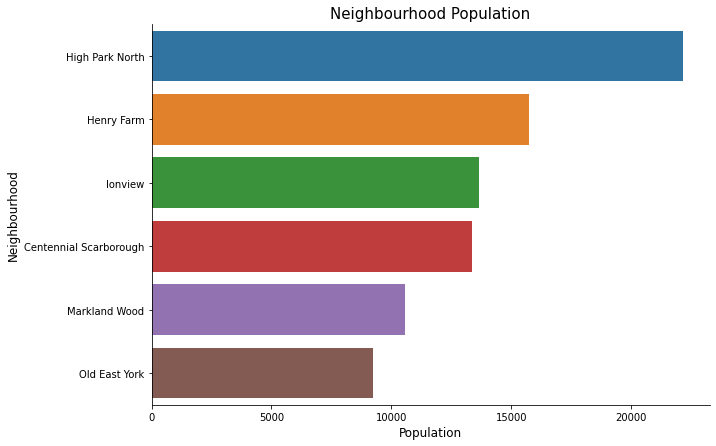

In [43]:
f, ax = plt.subplots(figsize=(10,7))
sns.barplot(x='Population', y = 'Neighbourhood', data=df_fil.sort_values(by='Population', ascending=False))
ax.set_title("Neighbourhood Population")
sns.despine(top=True)
plt.show()

Now we can further narrow down our search by picking the top 5 most populated neighbourhoods in the cluster.

In [44]:
df_fil = df_fil.sort_values(by="Population", ascending=False).head().reset_index(drop=True)
df_fil

,Neighbourhood,Population,Assault_2014,Assault_2015,Assault_2016,Assault_2017,Assault_2018,Assault_2019,AutoTheft_2014,AutoTheft_2015,AutoTheft_2016,AutoTheft_2017,AutoTheft_2018,AutoTheft_2019,BreakandEnter_2014,BreakandEnter_2015,BreakandEnter_2016,BreakandEnter_2017,BreakandEnter_2018,BreakandEnter_2019,Homicide_2014,Homicide_2015,Homicide_2016,Homicide_2017,Homicide_2018,Homicide_2019,Robbery_2014,Robbery_2015,Robbery_2016,Robbery_2017,Robbery_2018,Robbery_2019,TheftOver_2014,TheftOver_2015,TheftOver_2016,TheftOver_2017,TheftOver_2018,TheftOver_2019
0,High Park North,22162,79,90,89,99,101,87,7,14,7,9,20,24,18,70,28,54,61,68,1,0,0,0,0,0,13,22,23,31,24,13,5,1,2,2,4,5
1,Henry Farm,15723,64,69,72,74,81,85,14,12,10,15,16,23,38,27,13,28,25,37,0,1,0,1,1,0,5,8,8,12,8,7,2,4,1,10,5,14
2,Ionview,13641,95,107,101,93,90,79,5,12,5,6,3,8,33,45,17,28,19,19,0,0,0,0,0,0,24,15,9,13,8,11,1,5,4,1,1,2
3,Centennial Scarborough,13362,50,39,48,48,46,48,8,7,5,8,10,19,13,15,19,23,16,29,0,0,0,1,1,0,10,4,13,11,6,1,1,1,1,4,2,3
4,Markland Wood,10554,23,12,24,24,24,17,8,15,13,9,20,9,53,19,19,13,25,26,0,0,0,0,0,0,8,3,11,9,4,12,3,2,2,1,2,3


### Visualize Crime Trend

Since our crime dataframe contains data for yearly crime counts, lets define a function that will break down the dataset by taking the year, neighbourhood, and dataframe as a parameter. This will allow us to analyze the crime rate for each neighbourhood per year. The function returns two lists:
1. Sum of crime counts for a given year and neighbourhood
2. Crime per 1000 population for a given year and neighbourhood

We can then plot the yearly crime count for each neighbourhood and evaluate the ideal neighbourhood to start a restaurant business.

In [45]:
def get_total(df, hood, years):
    total = []
    crime_per_1000 = []
    for year in years:
        cols = [x for x in df.columns if x.endswith(year)]
        t = df.loc[df['Neighbourhood'] == hood, cols].sum(axis=1).values[0]
        c = round(t*1000/df.loc[df['Neighbourhood'] == hood, 'Population'].values[0], 2)
        total.append(t)
        crime_per_1000.append(c)
        
    return total, crime_per_1000



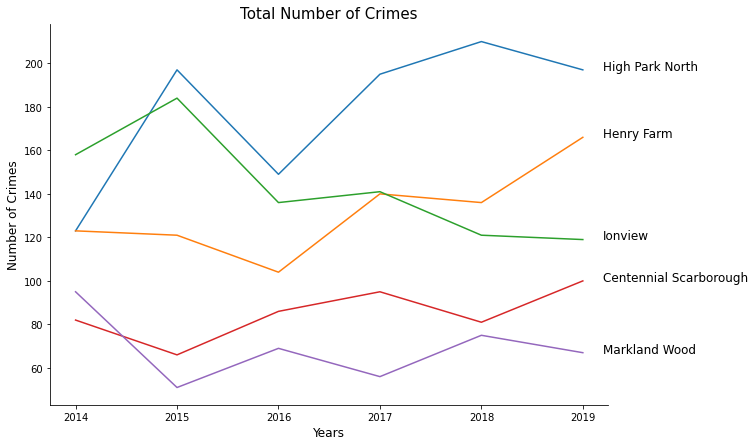

In [46]:
years = ['2014', '2015', '2016', '2017', '2018', '2019']

f, ax1 = plt.subplots(figsize=(10, 7))
counter = 0
for hood in df_fil['Neighbourhood']:
    total, crime_per_1000 = get_total(df_fil, hood, years)
    
    ax1.plot(years, total, label=hood)
    ax1.set_title("Total Number of Crimes")
    ax1.set_xlabel("Years")
    ax1.set_ylabel("Number of Crimes")
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.annotate(hood, xy=(len(years)-0.8,total[-1]), fontsize=12)
    
    

As we can see, in terms of the total count of crimes, Rough ranks the highest count and Henry Farm has the lowest crime occurance while rest of the 3 neighbourhoods have quite similar behaviour. Keep in mind that this graph does not take into account the difference in population density of their respective neighbourhoods.

So now lets see what the graph looks like when we plot the data as total crimes per 1000 population.

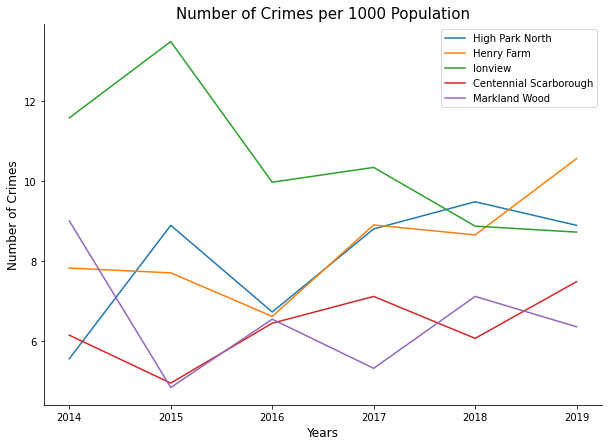

In [47]:
years = ['2014', '2015', '2016', '2017', '2018', '2019']

f, ax2 = plt.subplots(figsize=(10, 7))
counter = 0
for hood in df_fil['Neighbourhood']:
    total, crime_per_1000 = get_total(df_fil, hood, years)
    
    ax2.plot(years, crime_per_1000, label=hood)
    ax2.set_title("Number of Crimes per 1000 Population")
    ax2.set_xlabel("Years")
    ax2.set_ylabel("Number of Crimes")
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.legend()
    

Here, we see almost opposite of what we saw earlier. In this graph, which we can consider as the data being normalized by taking the population into account, Rouge and Banbury has the least number of crime occurance per 1000 population while Henry Farm ranks the highest. 